In [1]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from transformers import AutoTokenizer, Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq, AutoModelForSeq2SeqLM
from datasets import load_metric
from datasets import Dataset, DatasetDict
import torch
import os
import random
from tqdm import tqdm
import numpy as np

In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [3]:
import sys
sys.path.insert(0, '../src')
from metrics import metrics

In [4]:
MAX_LENGTH = 85

In [5]:
df = pd.read_csv('../data/internal/preprocessed.csv', index_col=0)

In [6]:
model_name = 'SkolkovoInstitute/bart-base-detox'

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name, model_max_length=MAX_LENGTH, cache_dir=f"../.cache/tokenizers/{model_name}")

In [12]:
VOCAB_SIZE = len(tokenizer)

In [13]:
train_ratio = 0.8
val_test_ratio = 0.5

ref_train, ref_val, trn_train, trn_val = train_test_split(df['reference'].tolist(), df['translation'].tolist(), test_size=(1-train_ratio), random_state=42)
ref_val, ref_test, trn_val, trn_test = train_test_split(ref_val, trn_val, test_size=val_test_ratio, random_state=42)

In [14]:
train_data = pd.DataFrame({'input_text': ref_train, 'target_text': trn_train})
val_data = pd.DataFrame({'input_text': ref_val, 'target_text': trn_val})
test_data = pd.DataFrame({'input_text': ref_test, 'target_text': trn_test})

In [15]:
raw_datasets = DatasetDict({
    'train': Dataset.from_pandas(train_data),
    'validation': Dataset.from_pandas(val_data),
    'test': Dataset.from_pandas(test_data)
})

In [16]:
prefix = "paraphrase:"
source_lang = "input_text"
target_lang = "target_text"


def preprocess_function(examples):
    inputs = [prefix + ex for ex in examples['input_text']]
    targets = [ex for ex in examples['target_text']]
    model_inputs = tokenizer(inputs, max_length=MAX_LENGTH, truncation=True)

    # Setup the tokenizer for targets
    labels = tokenizer(targets, max_length=MAX_LENGTH, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [17]:
tokenized_datasets = raw_datasets.map(preprocess_function, batched=True)

Map:   0%|          | 0/80584 [00:00<?, ? examples/s]

Map:   0%|          | 0/10073 [00:00<?, ? examples/s]

Map:   0%|          | 0/10074 [00:00<?, ? examples/s]

In [69]:
load_ckpt_path = f'../models/{model_name}'
model_ckpt_path = load_ckpt_path+'/best'
ckpt_path = model_ckpt_path+'_checkpoint.pt'

isCkptExists = os.path.isdir(model_ckpt_path)

if not isCkptExists:
    print('Checkpoint file does not exist. Training model from scratch!')
    model = AutoModelForSeq2SeqLM.from_pretrained(model_name, cache_dir=f"../.cache/models/{model_name}")
    val_scores = []
    best = 0

    torch.save({
      'val_scores': val_scores,
      }, ckpt_path)
elif isCkptExists:
    model = AutoModelForSeq2SeqLM.from_pretrained(model_ckpt_path)

In [56]:
BATCH_SIZE = 64

args = Seq2SeqTrainingArguments(
    f"../models/{model_name}",
    evaluation_strategy = "steps",
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    weight_decay=0.01,
    save_total_limit=1,
    num_train_epochs=10,
    predict_with_generate=True,
    # generation_max_length=MAX_LENGTH,
    fp16=True,
    save_steps=500,
    eval_steps=500,
    logging_steps=100,
)

In [57]:
# instead of writing collate_fn function we will use DataCollatorForSeq2Seq
# simliarly it implements the batch creation for training
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [58]:
import matplotlib.pyplot as plt

def showPlot(val_scores):
    plt.figure()
    plt.plot(val_scores, label='BLUE score')
    plt.legend(loc="upper right")
    plt.title(f'Scores on epoch {len(val_scores)}')
    plt.show()

In [59]:
blue_metric = load_metric("sacrebleu")

# simple postprocessing for text
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels

# compute metrics function to pass to trainer
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = blue_metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)

    checkpoint = torch.load(ckpt_path)
    val_scores = checkpoint['val_scores']

    val_scores.append(result["bleu"])

    showPlot(val_scores)

    best = max(val_scores)

    torch.save({
      'val_scores': val_scores,
      }, ckpt_path)

    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [60]:
# instead of writing train loop we will use Seq2SeqTrainer
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

You're using a BartTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Bleu,Gen Len
500,1.543100,1.413283,35.164200,20.000000
1000,1.443600,1.347961,35.559800,20.000000
1500,1.340400,1.312207,36.065500,20.000000
2000,1.300000,1.298067,36.419700,20.000000
2500,1.296900,1.272375,36.766100,20.000000
3000,1.214100,1.270200,36.879100,20.000000
3500,1.215400,1.256751,36.527800,20.000000
4000,1.160000,1.255071,36.820800,20.000000
4500,1.160900,1.245662,37.449300,20.000000
5000,1.162900,1.234690,37.642400,20.000000


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


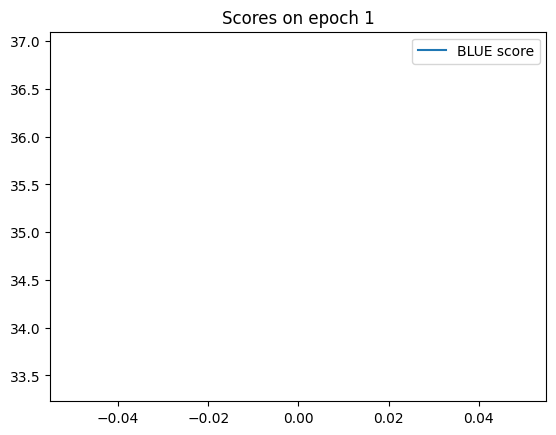

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


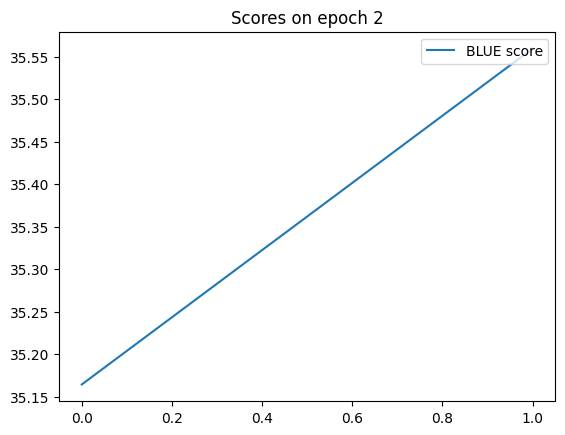

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


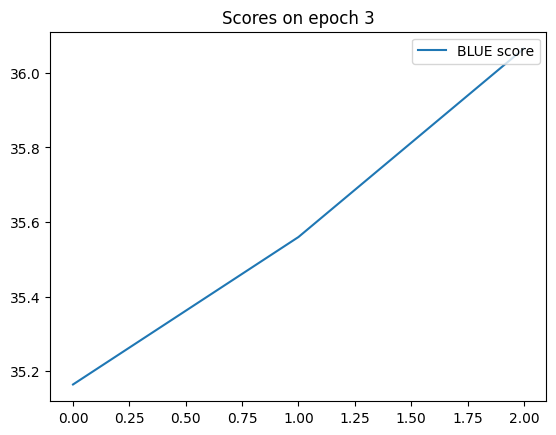

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


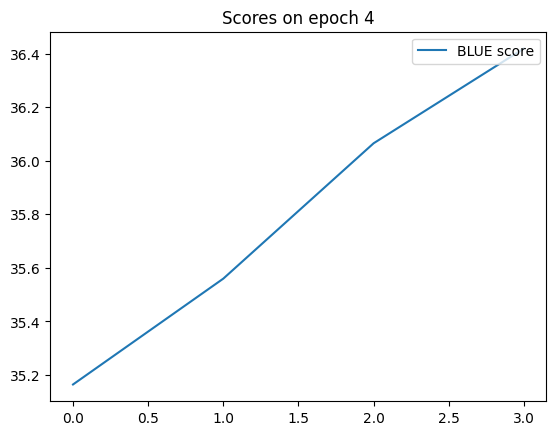

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


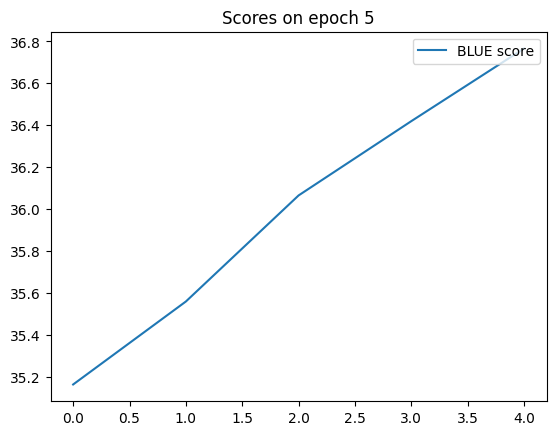

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


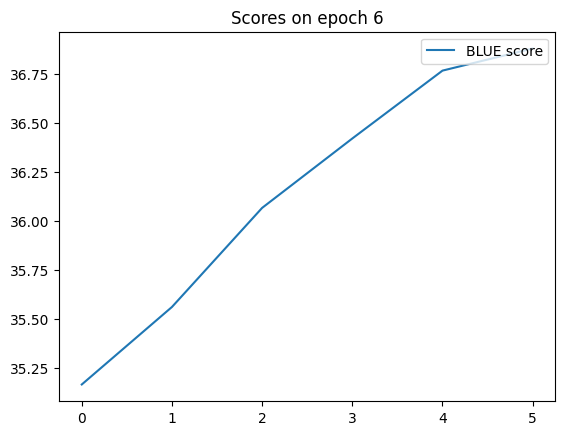

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


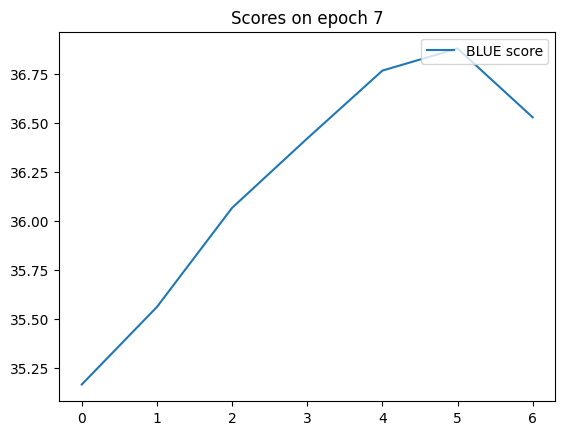

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


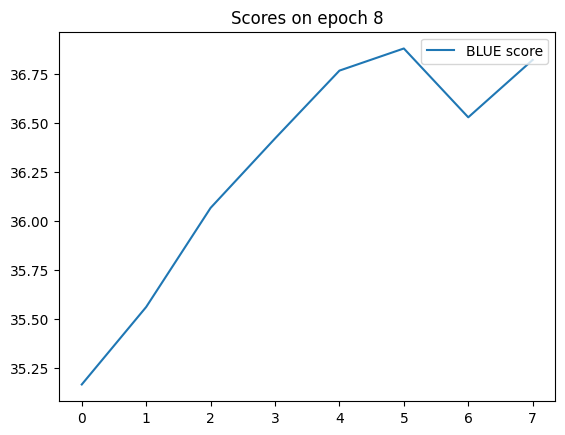

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


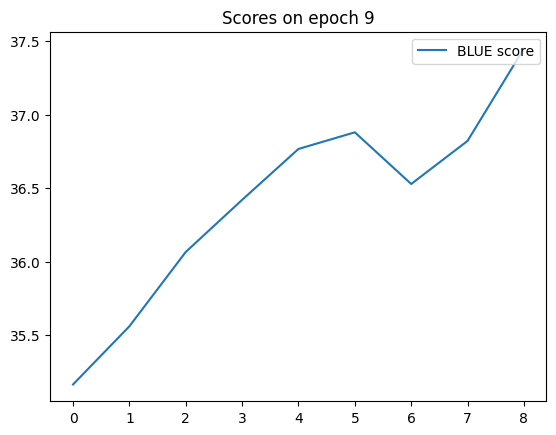

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


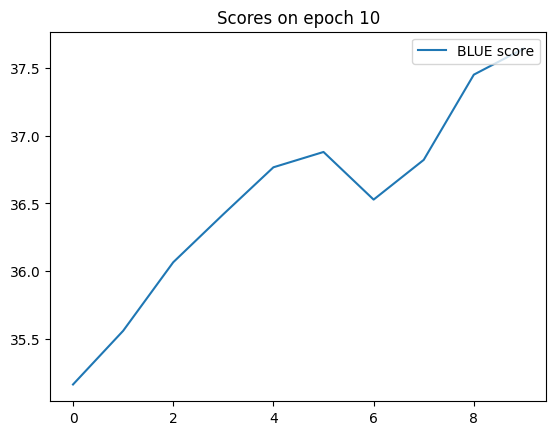

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


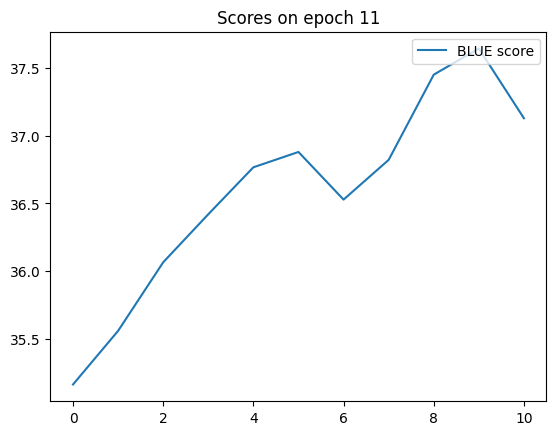

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


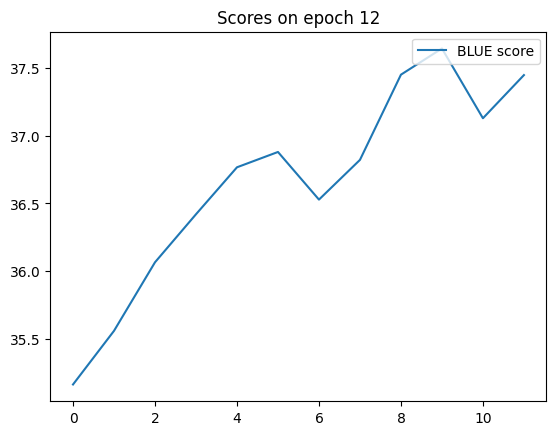

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


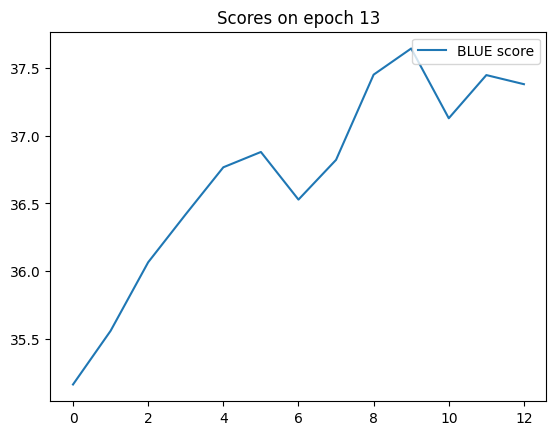

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


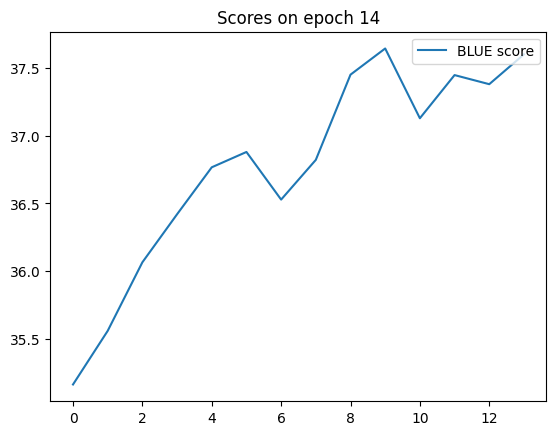

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


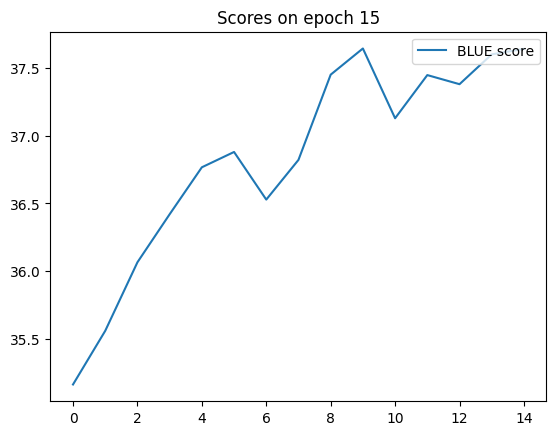

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


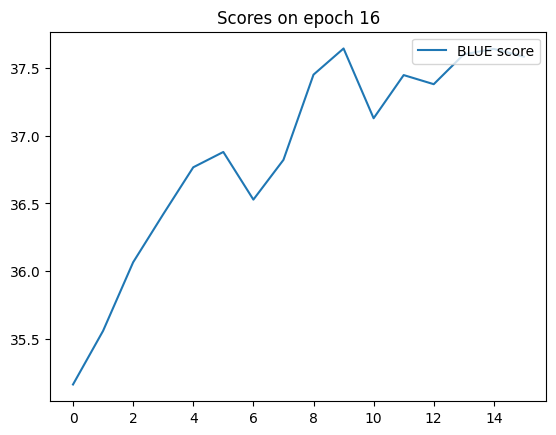

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


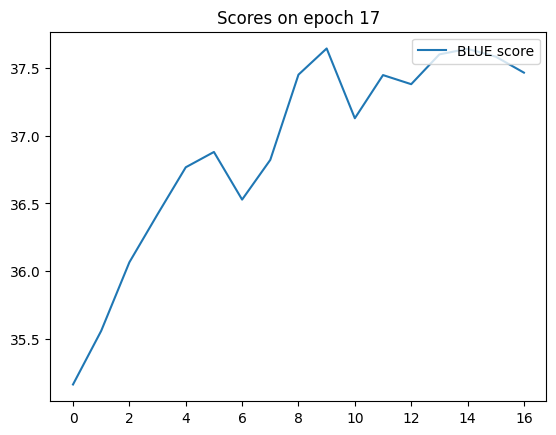

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


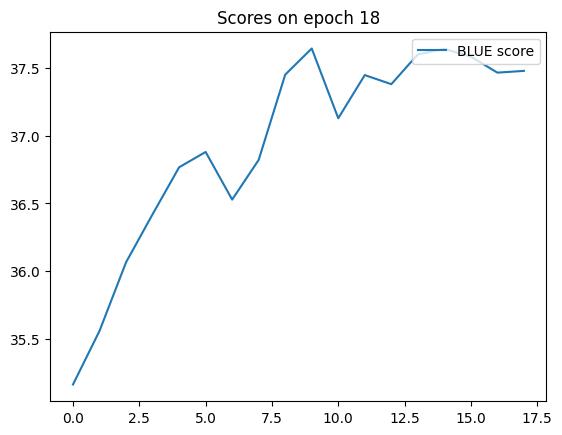

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


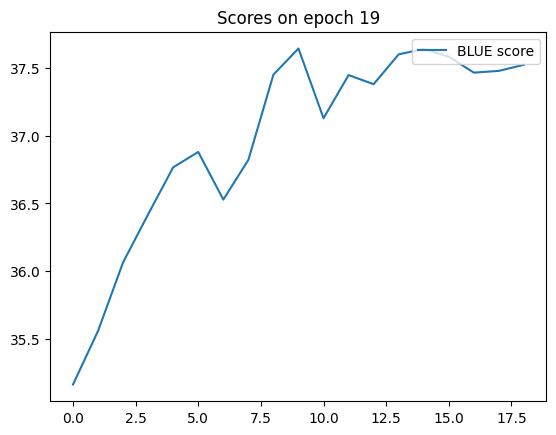

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


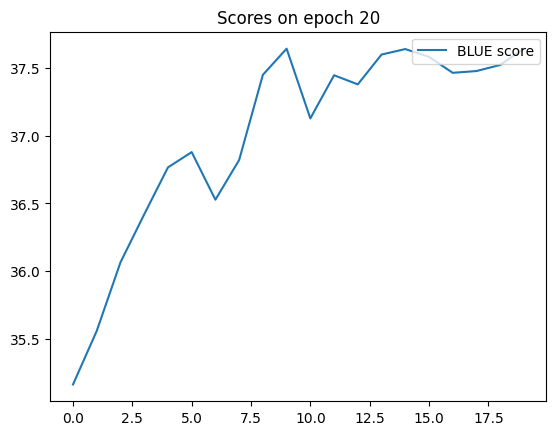

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


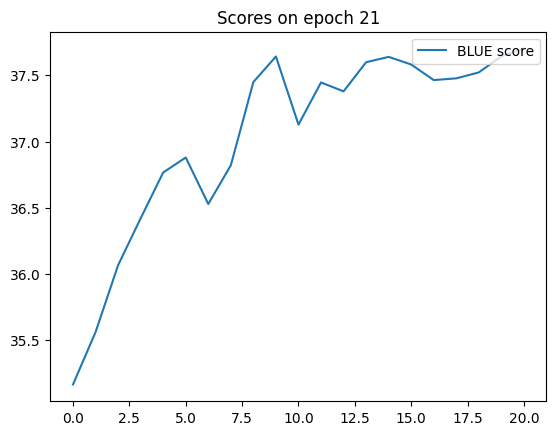

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


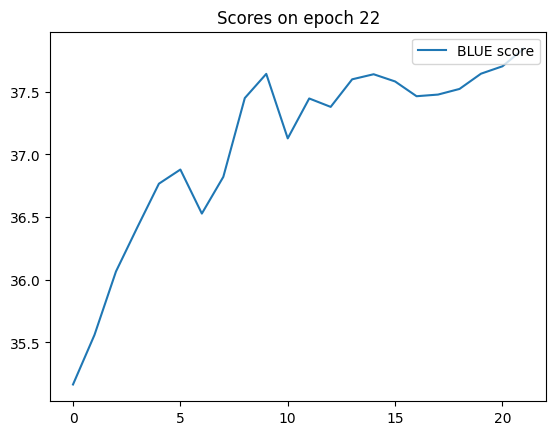

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


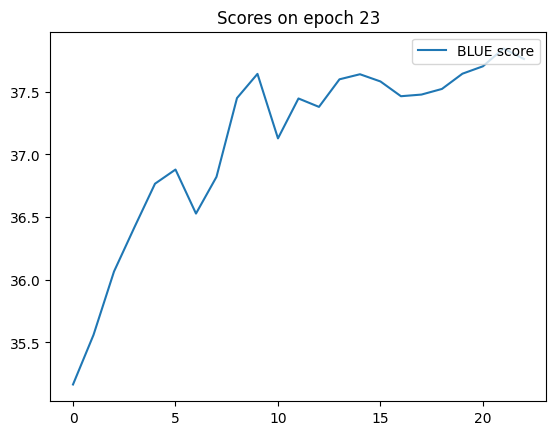

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


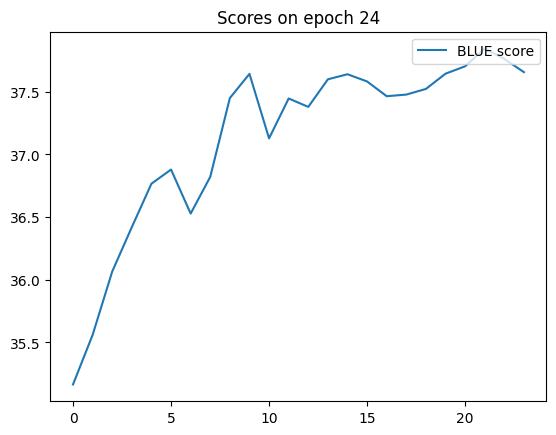

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


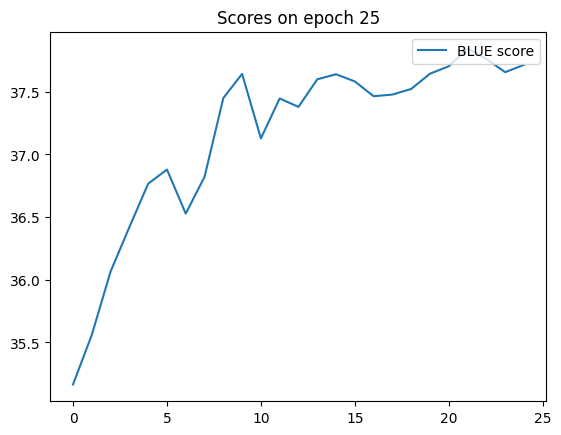

TrainOutput(global_step=12600, training_loss=1.1398422598460365, metrics={'train_runtime': 4280.9965, 'train_samples_per_second': 188.237, 'train_steps_per_second': 2.943, 'total_flos': 1.556663370522624e+16, 'train_loss': 1.1398422598460365, 'epoch': 10.0})

In [61]:
trainer.train()

In [ ]:
trainer.save_model(f'../models/{model_name}/test_best')

In [18]:
model = AutoModelForSeq2SeqLM.from_pretrained(f'../models/{model_name}/best')
model.eval()
model.config.use_cache = False

In [19]:
def translate(model, inference_request, tokenizer=tokenizer):
    input_ids = tokenizer(inference_request, return_tensors="pt").input_ids
    outputs = model.generate(input_ids=input_ids, max_new_tokens=MAX_LENGTH)
    return tokenizer.decode(outputs[0], skip_special_tokens=True,temperature=0)

In [20]:
inference_request = prefix + 'I was perferctly done, but stupidly finished.'
translate(model, inference_request,tokenizer)

'I was very well done, but I was very poorly done.'

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

In [27]:
def test_model(dataset, model):      
      model.eval()
    
      bar = tqdm(dataset, desc='Evaluation')

      output_texts = []
      target_texts = []
 
      for sample in bar:
            input_text = sample['input_text']
            target_text = sample['target_text']
            
            output_text = translate(model, input_text)
            
            output_texts.append(output_text)
            target_texts.append(target_text)
            
            
      blue_score = metrics.blue(output_texts, target_texts)
      similarity_score = metrics.content_similarity({'device':device, 'batch_size':512}, output_texts, target_texts)
      fluency_score = metrics.fluency({'device':device, 'batch_size':256}, output_texts)
      sta_score = metrics.style_transfer_accuracy({'device':device, 'batch_size':256}, output_texts)
 
      return blue_score, similarity_score, fluency_score, sta_score

In [28]:
import gc
torch.cuda.empty_cache()
gc.collect()

15

In [29]:
blue_score, similarity_score, fluency_score, sta_score = test_model(raw_datasets['test'], model)

100%|██████████| 20/20 [00:38<00:00,  1.93s/it]


Calculating style of predictions


Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
print('BLUE:', blue_score)
print('Similarity:', similarity_score)
print('Fluency:', fluency_score)
print('STA:', sta_score)

BLUE: 37.89366468762542
Similarity: 0.841663658618927
Fluency: 0.9217923879623413
STA: 9.926541679305956e-05
